In [1]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

import numpy as np
#from scipy.interpolate import interp2d
import pandas as pd 
from itertools import permutations, product, combinations
import idaes
from itertools import permutations, product

from fim_doe import *

import pyomo.common.unittest as unittest

In [2]:
import cvxpy as cp

from reactor_kinetics import *

(CVXPY) Aug 16 05:38:07 PM: Encountered unexpected exception importing solver GUROBI:
ImportError('libgurobi95.so: cannot open shared object file: No such file or directory')
(CVXPY) Aug 16 05:38:07 PM: Encountered unexpected exception importing solver GUROBI:
ImportError('libgurobi95.so: cannot open shared object file: No such file or directory')


## FIM generator

In [3]:
def generate_exp(t_set, CA0, T):  
    '''Generate experiments. 
    t_set: time control set for T.
    CA0: CA0 value
    T: A list of T 
    '''
    assert(len(t_set)==len(T)), 'T should have the same length as t_set'
    
    T_con_initial = {}
    for t, tim in enumerate(t_set):
        T_con_initial[tim] = T[t]
        
    dv_dict_overall = {'CA0': {0: CA0},'T': T_con_initial}
    return dv_dict_overall

In [4]:
def return_FIM(measure_pass):
    # Create model function
    createmod = create_model

    # discretization by Pyomo.DAE
    disc = disc_for_measure

    # Control time set [h]
    t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

    

    # design variable and its control time set
    dv_pass = {'CA0': [0],'T': t_control}

    t_test = [0.125, 0.375, 0.625, 0.875]

    
    measure_class =  Measurements(measure_pass)

    # Define parameter nominal value 
    parameter_dict = {'A1': 84.79085853498033, 'A2': 371.71773413976416, 'E1': 7.777032028026428, 'E2': 15.047135137500822}
    
    # empty prior
    prior_all = np.zeros((4,4))

    prior_pass=np.asarray(prior_all)

    print('The prior information FIM:', prior_pass)
    

    # choose from 'sequential_finite', 'direct_kaug'
    # 'sequential_sipopt', 'sequential_kaug' is also available
    sensi_opt = 'sequential_finite'
    #sensi_opt = 'direct_kaug'

    # model option
    if sensi_opt == 'direct_kaug':
        args_ = [False]
    else:
        args_ = [True]


    # Define experiments
    exp1 = generate_exp(t_control, 5, [570, 300, 300, 300, 300, 300, 300, 300, 300])
    
    doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=args_, verbose=False)


    result = doe_object.compute_FIM(exp1,mode=sensi_opt, FIM_store_name = 'dynamic.csv', scale_nominal_param_value=True, 
                                    store_output = 'store_output', read_output=None,tee_opt=False,
                                    formula='central')


    result.calculate_FIM(doe_object.design_values)
    
    
    print('======Result summary======')
    print('Four design criteria log10() value:')
    print('A-optimality:', np.log10(result.trace))
    print('D-optimality:', np.log10(result.det))
    print('E-optimality:', np.log10(result.min_eig))
    print('Modified E-optimality:', np.log10(result.cond))
    
    return result.FIM, result.jaco_information

In [5]:
# Create measurement object
# Measurement time points [h]
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

measure_pass = {'C':{'CA': t_measure, 'CB': t_measure, 'CC': t_measure}}
#measure_pass = {'C':{'CC': t_test}}

In [6]:
fim1, jaco1 = return_FIM(measure_pass)
print(jaco1)

All measurements are flattened.
Flatten measurement name: ['C_index_CA', 'C_index_CB', 'C_index_CC']
The prior information FIM: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Sensitivity information is scaled by its corresponding parameter nominal value.
Existed information has been added.
FIM: [[  17.66733763   18.74907479  -30.09833141  -76.66335672]
 [  18.74907479   30.78667315  -30.04626402 -124.88329795]
 [ -30.09833141  -30.04626402   52.08798793  123.38481043]
 [ -76.66335672 -124.88329795  123.38481043  514.04755797]]
Trace: 614.5895566797835
Determinant: 663.4981277560081
Condition number: 6044.997967150994
Minimal eigen value: 0.09719821768019567
Eigen values: [5.87563028e+02 2.64907667e+01 9.71982177e-02 4.38563426e-01]
Eigen vectors: [[ 0.14552155  0.4403084   0.86473015  0.19285682]
 [ 0.2270364  -0.06216021 -0.21780144  0.94718167]
 [-0.23603479 -0.85419248  0.4513987   0.10431684]
 [-0.93357674  0.26948066 -0.03230349  0.23403233]]
======Result summary====

### Jacobian generator

In [7]:
jaco = pd.DataFrame(jaco1)
jaco.to_csv('./kinetics_fim/Q.csv')

### FIM generator

In [8]:
FIM_set = []

def to_dataframe(fim_list):
    
    fim_dict = {'P1': fim_list[0], 
               'P2': fim_list[1],
               'P3': fim_list[2], 
               'P4': fim_list[3]
               }
    fim_frame = pd.DataFrame(fim_dict)
    
    return fim_frame

In [9]:
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
#t_measure = [0]

#measure_pass = {'C':{'CA': t_measure, 'CB': t_measure, 'CC': t_measure}}
#measure_pass = {'C':{'CC': t_test}}

for idx, i in enumerate(t_measure):
    measure_pass = {'C':{'CA': [i]}}
    fim1, _ = return_FIM(measure_pass)
    FIM_set.append(fim1)
    print('FIM for CA, time ', i, ':', fim1)
    fim1_dataframe = to_dataframe(fim1)
    fim1_dataframe.to_csv('./kinetics_fim/CA_'+str(idx)+'.csv')
    
for idx, i in enumerate(t_measure):
    measure_pass = {'C':{'CB': [i]}}
    fim1, _ = return_FIM(measure_pass)
    FIM_set.append(fim1)
    print('FIM for CB, time ', i, ':', fim1)
    fim1_dataframe = to_dataframe(fim1)
    fim1_dataframe.to_csv('./kinetics_fim/CB_'+str(idx)+'.csv')
    
for idx, i in enumerate(t_measure):
    measure_pass = {'C':{'CC': [i]}}
    fim1, _ = return_FIM(measure_pass)
    FIM_set.append(fim1)
    print('FIM for CC, time ', i, ':', fim1)
    fim1_dataframe = to_dataframe(fim1)
    fim1_dataframe.to_csv('./kinetics_fim/CC_'+str(idx)+'.csv')

All measurements are flattened.
Flatten measurement name: ['C_index_CA']
The prior information FIM: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Sensitivity information is scaled by its corresponding parameter nominal value.
Existed information has been added.
The condition number is: inf ;
A condition number bigger than  1000000000000.0  is considered near singular.
FIM: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Trace: 0.0
Determinant: 0.0
Condition number: nan
Minimal eigen value: 0.0
Eigen values: [0. 0. 0. 0.]
Eigen vectors: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
======Result summary======
Four design criteria log10() value:
A-optimality: -inf
D-optimality: -inf
E-optimality: -inf
Modified E-optimality: nan
FIM for CA, time  0 : [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
All measurements are flattened.
Flatten measurement name: ['C_index_CA']
The prior information FIM: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0

/media/psf/Home/dowlinglab/measurement-opt/fim_doe.py:2259: RuntimeWarning: invalid value encountered in double_scalars
  self.cond = max(eig) / min(eig)
/tmp/ipykernel_83608/3679787686.py:62: RuntimeWarning: divide by zero encountered in log10
  print('A-optimality:', np.log10(result.trace))
/tmp/ipykernel_83608/3679787686.py:63: RuntimeWarning: divide by zero encountered in log10
  print('D-optimality:', np.log10(result.det))
/tmp/ipykernel_83608/3679787686.py:64: RuntimeWarning: divide by zero encountered in log10
  print('E-optimality:', np.log10(result.min_eig))


Existed information has been added.
The condition number is: 2.3544731243922475e+42 ;
A condition number bigger than  1000000000000.0  is considered near singular.
FIM: [[ 1.81358855e+00  2.24269839e-13 -2.99421545e+00  2.24269839e-13]
 [ 2.24269839e-13  2.77333912e-26 -3.70267125e-13  2.77333912e-26]
 [-2.99421545e+00 -3.70267125e-13  4.94341794e+00 -3.70267125e-13]
 [ 2.24269839e-13  2.77333912e-26 -3.70267125e-13  2.77333912e-26]]
Trace: 6.757006486538057
Determinant: 0.0
Condition number: -1.0142440673645765e+29
Minimal eigen value: -6.662110929665618e-29
Eigen values: [ 0.00000000e+00  6.75700649e+00  1.14682266e-41 -6.66211093e-29]
Eigen vectors: [[-8.55335499e-01 -5.18074497e-01  8.55335499e-01  8.55335499e-01]
 [ 3.88600949e-14 -6.41576045e-14 -3.88600949e-14  1.05923524e-13]
 [-5.18074497e-01  8.55335499e-01  5.18074497e-01  5.18074497e-01]
 [ 3.88043165e-14 -6.40655149e-14  1.48479403e-13  1.05771485e-13]]
======Result summary======
Four design criteria log10() value:
A-optim

/tmp/ipykernel_83608/3679787686.py:64: RuntimeWarning: invalid value encountered in log10
  print('E-optimality:', np.log10(result.min_eig))
/tmp/ipykernel_83608/3679787686.py:65: RuntimeWarning: invalid value encountered in log10
  print('Modified E-optimality:', np.log10(result.cond))


Existed information has been added.
The condition number is: inf ;
A condition number bigger than  1000000000000.0  is considered near singular.
FIM: [[ 1.08013833e+00  2.30770300e-13 -2.08328764e+00  1.73077725e-13]
 [ 2.30770300e-13  4.93038066e-26 -4.45091986e-13  3.69778549e-26]
 [-2.08328764e+00 -4.45091986e-13  4.01808481e+00 -3.33818990e-13]
 [ 1.73077725e-13  3.69778549e-26 -3.33818990e-13  2.77333912e-26]]
Trace: 5.098223136660172
Determinant: 0.0
Condition number: -5740088954628597.0
Minimal eigen value: -8.881784197001252e-16
Eigen values: [-8.88178420e-16  5.09822314e+00 -2.80259693e-42  9.56529353e-29]
Eigen vectors: [[-8.87769315e-01 -4.60288653e-01 -4.77949090e-14  3.49684417e-01]
 [ 5.07966122e-14 -9.79725947e-14 -2.93998466e-14  8.26299890e-01]
 [-4.60288653e-01  8.87769315e-01  5.82985321e-14  1.81303596e-01]
 [ 3.82403808e-14 -7.37551022e-14  1.00000000e+00  4.02589500e-01]]
======Result summary======
Four design criteria log10() value:
A-optimality: 0.70741883954821

/media/psf/Home/dowlinglab/measurement-opt/fim_doe.py:2259: RuntimeWarning: divide by zero encountered in double_scalars
  self.cond = max(eig) / min(eig)
/tmp/ipykernel_83608/3679787686.py:63: RuntimeWarning: invalid value encountered in log10
  print('D-optimality:', np.log10(result.det))


Existed information has been added.
The condition number is: 3.0375174631173404e+42 ;
A condition number bigger than  1000000000000.0  is considered near singular.
FIM: [[ 7.82855525e-02  1.55317734e-14 -1.91111306e-01  5.82441501e-15]
 [ 1.55317734e-14  3.08148791e-27 -3.79162872e-14  1.15555797e-27]
 [-1.91111306e-01 -3.79162872e-14  4.66542423e-01 -1.42186077e-14]
 [ 5.82441501e-15  1.15555797e-27 -1.42186077e-14  4.33334237e-28]]
Trace: 0.5448279752225464
Determinant: 0.0
Condition number: inf
Minimal eigen value: 0.0
Eigen values: [0.00000000e+00 5.44827975e-01 0.00000000e+00 8.31991395e-44]
Eigen vectors: [[-9.25370969e-01  3.79062752e-01  0.00000000e+00 -9.25370969e-01]
 [ 3.08057950e-14  7.52033490e-14  1.00000000e+00 -1.34540164e-13]
 [-3.79062752e-01 -9.25370969e-01  8.12683254e-14 -3.79062752e-01]
 [ 1.15525283e-14  2.82021230e-14  3.04765591e-14  1.90044663e-13]]
======Result summary======
Four design criteria log10() value:
A-optimality: -0.2637406008514066
D-optimality: -

Existed information has been added.
The condition number is: 7.579362948155853e+32 ;
A condition number bigger than  1000000000000.0  is considered near singular.
FIM: [[ 0.24530723  0.69416981 -0.24627965 -2.63559089]
 [ 0.69416981  1.96436006 -0.69692157 -7.45818877]
 [-0.24627965 -0.69692157  0.24725593  2.64603865]
 [-2.63559089 -7.45818877  2.64603865 28.3168961 ]]
Trace: 30.77381932156598
Determinant: 0.0
Condition number: -2.124909552705877e+17
Minimal eigen value: -1.448241374903622e-16
Eigen values: [ 0.00000000e+00  3.07738193e+01 -1.44824137e-16 -3.69778549e-32]
Eigen vectors: [[-0.99600638 -0.08928212  0.55945177  0.99600638]
 [ 0.0226476  -0.25265032  0.61456565 -0.0226476 ]
 [-0.00803498  0.08963604 -0.49171409  0.00803498]
 [-0.08598733  0.9592507   0.25988467  0.08598733]]
======Result summary======
Four design criteria log10() value:
A-optimality: 1.4881813996386075
D-optimality: -inf
E-optimality: nan
Modified E-optimality: nan
FIM for CB, time  0.375 : [[ 0.24530723 

/media/psf/Home/dowlinglab/measurement-opt/fim_doe.py:2259: RuntimeWarning: divide by zero encountered in cdouble_scalars
  self.cond = max(eig) / min(eig)
/media/psf/Home/dowlinglab/measurement-opt/fim_doe.py:2259: RuntimeWarning: invalid value encountered in cdouble_scalars
  self.cond = max(eig) / min(eig)


Existed information has been added.
The condition number is: inf ;
A condition number bigger than  1000000000000.0  is considered near singular.
FIM: [[ 0.54932733  0.99553419 -0.90988289 -4.67555134]
 [ 0.99553419  1.80418536 -1.64896133 -8.47340185]
 [-0.90988289 -1.64896133  1.50709207  7.74438828]
 [-4.67555134 -8.47340185  7.74438828 39.79554456]]
Trace: 43.65614932719603
Determinant: 0.0
Condition number: -2.4695412135814346e+17
Minimal eigen value: -1.767783792677993e-16
Eigen values: [ 0.00000000e+00  4.36561493e+01 -1.76778379e-16  1.35083614e-15]
Eigen vectors: [[-0.99368856 -0.11217418 -0.03765101  0.43645126]
 [ 0.02294883 -0.20329087 -0.18966672  0.69683977]
 [-0.02097441  0.18580063 -0.97049334 -0.48706433]
 [-0.10777974  0.95476065  0.14405421  0.2944367 ]]
======Result summary======
Four design criteria log10() value:
A-optimality: 1.6400454262952087
D-optimality: -inf
E-optimality: nan
Modified E-optimality: nan
FIM for CB, time  1 : [[ 0.54932733  0.99553419 -0.909882

Existed information has been added.
The condition number is: 2.6216535870249177e+32 ;
A condition number bigger than  1000000000000.0  is considered near singular.
FIM: [[ 1.08964576  1.45756132 -1.91899665 -6.45164393]
 [ 1.45756132  1.94970246 -2.56694001 -8.63002183]
 [-1.91899665 -2.56694001  3.37958286 11.36211745]
 [-6.45164393 -8.63002183 11.36211745 38.19930391]]
Trace: 44.61823498666349
Determinant: 0.0
Condition number: (-2.7748009935828252e+16+6.993704301381606e+16j)
Minimal eigen value: (-2.1869566578282003e-16-5.512081125875411e-16j)
Eigen values: [ 0.00000000e+00+0.00000000e+00j  4.46182350e+01+0.00000000e+00j
 -2.18695666e-16+5.51208113e-16j -2.18695666e-16-5.51208113e-16j]
Eigen vectors: [[-0.98771376+0.j         -0.15627391+0.j          0.03349925-0.40839212j
   0.03349925+0.40839212j]
 [ 0.03307374+0.j         -0.20903932+0.j          0.69749208+0.j
   0.69749208-0.j        ]
 [-0.04354424+0.j          0.27521706+0.j         -0.17006478+0.47604325j
  -0.17006478-0.476

In [10]:
print(np.shape(FIM_set))

print(FIM_set[0][1,1])

print(FIM_set)

(27, 4, 4)
0.0
[array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), array([[ 1.81358855e+00,  2.24269839e-13, -2.99421545e+00,
         2.24269839e-13],
       [ 2.24269839e-13,  2.77333912e-26, -3.70267125e-13,
         2.77333912e-26],
       [-2.99421545e+00, -3.70267125e-13,  4.94341794e+00,
        -3.70267125e-13],
       [ 2.24269839e-13,  2.77333912e-26, -3.70267125e-13,
         2.77333912e-26]]), array([[ 1.08013833e+00,  2.30770300e-13, -2.08328764e+00,
         1.73077725e-13],
       [ 2.30770300e-13,  4.93038066e-26, -4.45091986e-13,
         3.69778549e-26],
       [-2.08328764e+00, -4.45091986e-13,  4.01808481e+00,
        -3.33818990e-13],
       [ 1.73077725e-13,  3.69778549e-26, -3.33818990e-13,
         2.77333912e-26]]), array([[ 5.98013150e-01,  1.07318751e-13, -1.26660957e+00,
         8.58550009e-14],
       [ 1.07318751e-13,  1.92592994e-26, -2.27304294e-13,
         1.54074396e-26],
       [-1.26660957e+00, -2.

## FIM reader

In [11]:
def dataframe_return(data):
    fim1 = []
    fim1.append(data['P1'].to_list())
    fim1.append(data['P2'].to_list())
    fim1.append(data['P3'].to_list())
    fim1.append(data['P4'].to_list())
    
    return fim1 

In [12]:
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

#t_measure = [0.125]



def FIM_reader(rank='onebyone'):
    
    FIM_set = []
    
    if rank=='onebyone':
        for idx, i in enumerate(t_measure):
            fim1_data = pd.read_csv('./kinetics_fim/CA_' + str(idx)+'.csv')
            
            fim1 = dataframe_return(fim1_data)
            FIM_set.append(fim1)
            
            fim2_data = pd.read_csv('./kinetics_fim/CB_' + str(idx)+'.csv')
            
            fim2 = dataframe_return(fim2_data)
            FIM_set.append(fim2)
            
            fim3_data = pd.read_csv('./kinetics_fim/CC_' + str(idx)+'.csv')
            
            fim3 = dataframe_return(fim3_data)
            FIM_set.append(fim3)
            
    elif rank=='onealong':
        for idx, i in enumerate(t_measure):
            fim1_data = pd.read_csv('./kinetics_fim/CA_' + str(idx)+'.csv')
            
            fim1 = dataframe_return(fim1_data)
            FIM_set.append(fim1)
            
        for idx, i in enumerate(t_measure):
            fim2_data = pd.read_csv('./kinetics_fim/CB_' + str(idx)+'.csv')
            
            fim2 = dataframe_return(fim2_data)
            FIM_set.append(fim2)
            
        for idx, i in enumerate(t_measure):
            fim3_data = pd.read_csv('./kinetics_fim/CC_' + str(idx)+'.csv')
            
            fim3 = dataframe_return(fim3_data)
            FIM_set.append(fim3)
            
            
    return FIM_set
        
FIM_set = FIM_reader(rank='onealong')
print(np.shape(FIM_set))
print(FIM_set[0][1][1])

(27, 4, 4)
0.0


In [13]:
TotalF = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        TotalF[i,j] = sum(FIM_set[k][i][j] for k in range(27))
        
print(TotalF)

print(np.trace(TotalF))
print(np.linalg.det(TotalF))
print(np.linalg.eigvals(TotalF))

[[  17.66733763   18.74907479  -30.09833141  -76.66335672]
 [  18.74907479   30.78667315  -30.04626402 -124.88329795]
 [ -30.09833141  -30.04626402   52.08798793  123.38481043]
 [ -76.66335672 -124.88329795  123.38481043  514.04755797]]
614.5895566797835
663.4981277559746
[5.87563028e+02 2.64907667e+01 9.71982177e-02 4.38563426e-01]


### Jacobian reader

In [14]:
jaco_info = pd.read_csv('./kinetics_fim/Q.csv')

#print(jaco_info)


Q_stack = []

for i in range(27):
    
    Q_res = [jaco_info['A1'].iloc[i], jaco_info['A2'].iloc[i], jaco_info['E1'].iloc[i], jaco_info['E2'].iloc[i]]
    
    
    Q_stack.append(Q_res)
    
print(Q_stack)

[[0.0, 0.0, 0.0, 0.0], [-1.346695417017152, -1.665334536937735e-13, 2.223379846162832, -1.6653345369377348e-13], [-1.039297035228287, -2.220446049250313e-13, 2.004516103508741, -1.6653345369377348e-13], [-0.7733130998612002, -1.3877787807814457e-13, 1.63790005416059, -1.1102230246251565e-13], [-0.560819154400885, -1.249000902703301e-13, 1.2648388615049688, -6.938893903907228e-14], [-0.3990444064009696, -4.8572257327350605e-14, 0.9415433202331, -2.081668171172168e-14], [-0.2797955547643657, -5.5511151231257833e-14, 0.6830391077798161, -2.081668171172168e-14], [-0.1939053002679436, -3.1225022567582534e-14, 0.486126099753268, -3.4694469519536138e-15], [-0.1331100105811684, -1.3877787807814455e-14, 0.3409191457896289, 1.040834085586084e-14], [0.0, 0.0, 0.0, 0.0], [0.0199157340269318, -1.3752037136890438, -0.0468172929494192, 4.379651748244728], [-0.2728277373608145, -1.38740313152641, 0.1675143115261734, 4.866408693837143], [-0.4952849992631014, -1.4015562993399122, 0.4972483613988609, 5.3

### FIM verificator

In [ ]:
#optimize_sol = [ 0, 0, 0, 
#                1, 1, 1, 1, 1, 1,
#                1, 1, 1, 1, 1, 1, 
#                0, 1, 1, 0, 1, 1,
#                0, 1, 1, 0, 1, 1]


SelectF = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        SelectF[i,j] = sum(FIM_set[k][i,j]*yi for k, yi in enumerate(optimize_sol))
        
print(SelectF)

print(np.trace(SelectF))
print(np.linalg.det(SelectF))
print(np.linalg.eigvals(SelectF))

## CVXPY problem

no variance

In [ ]:
no_res = 27

In [ ]:
def eval_fim(yi):
     
    fim = sum(yy*FIM_set[idx] for idx, yy in enumerate(yi))
    #fim = cp.bmat(FIM_set)
        
    return fim 

def a_opt(yi):
    fim = eval_fim(yi)
    #return cp.matrix_frac(np.identity(fim.shape==[0]), fim)
    return cp.trace(fim)
    
def d_opt(yi):
    fim = eval_fim(yi)
    return cp.log_det(fim)

def e_opt(yi):
    fim = eval_fim(yi)
    return -cp.lambda_min(fim)

In [ ]:
yi = cp.Variable(no_res, nonneg=True)

p_cons = [cp.sum(yi) <= 20]

for i in yi:
    p_cons += [i<=1]

obj = cp.Maximize(d_opt(yi))

problem = cp.Problem(obj, p_cons)

In [ ]:
print('Optimal value:', problem.solve(verbose=True))

print(yi.value)

## cvxpy problem 

With variance

In [ ]:
def eval_fim(ya, yb, yc):
     
    fim = sum(yy1*FIM_set[idx] for idx, yy1 in enumerate(ya))+sum(yy2*FIM_set[idx+9]*0.25 for idx, yy2 in enumerate(yb)) + sum(yy3*FIM_set[idx+18]*0.25 for idx, yy3 in enumerate(yc))
                
    return fim 

def a_opt(yi):
    fim = eval_fim(yi)
    #return cp.matrix_frac(np.identity(fim.shape==[0]), fim)
    return cp.trace(fim)
    
def d_opt(ya, yb, yc):
    fim = eval_fim(ya, yb, yc)
    return cp.log_det(fim)

def e_opt(yi):
    fim = eval_fim(yi)
    return -cp.lambda_min(fim)

In [ ]:
no_res_unit = 9

ya = cp.Variable(no_res_unit, nonneg=True)
yb = cp.Variable(no_res_unit, nonneg=True)
yc = cp.Variable(no_res_unit, nonneg=True)

p_cons = [cp.sum(ya*10) + cp.sum(yb*6) + cp.sum(yc*6) <= 80]

for i in ya:
    p_cons += [i<=1]
for j in yb:
    p_cons += [j<=1]
for d in yc:
    p_cons += [d<=1]
    
obj = cp.Maximize(d_opt(ya, yb, yc))

problem = cp.Problem(obj, p_cons)



In [ ]:
print('First time: Optimal value:', problem.solve(verbose=True, max_iters=150000))

print('Second time: Optimal value:', problem.solve(verbose=True, warm_start = True))

In [ ]:
print(ya.value)
print(yb.value)
print(yc.value)

## CVXPY problem - with covariance 

### Continuous 

In [ ]:
# variance 
variance = [1, # var_CA^2
            4, # var_CB^2
            8  # var_CC^2
           ]
covariance = [ 0.1, # cov_CA_CB | ti, 
               0.1, # cov_CA_CC | ti, 
               0.5 # cov_CB_CC | ti
]

# construct Sigma
sigma = np.zeros((27, 27))

for i in range(27):
    #for j in range(27):
        
        #if i==j:
    if i<9:
        sigma[i,i]=variance[0]
        sigma[i,i+9]=covariance[0]
        sigma[i,i+18]=covariance[1]
    elif 9<= i < 18:
        sigma[i,i]=variance[1]
        sigma[i,i-9]=covariance[0]
        sigma[i,i+9]=covariance[2]
    elif i>=18:
        sigma[i,i]=variance[2]
        sigma[i,i-18]=covariance[1]
        sigma[i,i-9]=covariance[2]
                
            
# check eigen values to make sure it's PSD 
print(np.linalg.eigvals(sigma))



In [ ]:
sigma_inv = np.linalg.inv(sigma)

In [ ]:
for i in range(9):
    for j in range(9):
        if sigma_inv[i,j] != sigma_inv[j,i]:
            print('wrong')
            
#print(sigma_inv)

print(np.linalg.eigvals(sigma_inv))
# verify: 

Q_array = np.asarray(Q_stack)

fim = Q_array.T@sigma_inv@Q_array

print(fim)
print('trace:', np.trace(fim))
print('det:', np.linalg.det(fim))
print('logdet:', np.log(np.linalg.det(fim)))
print('eig:', np.linalg.eigvals(fim))

In [ ]:
# construct FIMs. Expect 27*27 FIMs
# No 
print(np.shape(Q_stack))

Q_matrix = []
for i in range(27):
    Q_matrix.append(np.asarray(Q_stack[i]).reshape((4,1)))
# Q: [CA|t1, ..., CA|tN, CB|ti, ..., CC|ti, ...]

FIM_collection = []

for i in range(9):
    # yCA, CA
    mat = sigma_inv[i,i]*Q_matrix[i]@Q_matrix[i].T
    FIM_collection.append(mat)

for i in range(9):
    # yCA, CB
    FIM_collection.append(sigma_inv[i,i+9]*Q_matrix[i]@Q_matrix[i+9].T)

for i in range(9):
    # YCA, CC
    FIM_collection.append(sigma_inv[i,i+18]*Q_matrix[i]@Q_matrix[i+18].T)

for i in range(9,18): 
    FIM_collection.append(sigma_inv[i,i]*Q_matrix[i]@Q_matrix[i].T)

for i in range(9,18): 
    FIM_collection.append(sigma_inv[i,i-9]*Q_matrix[i]@Q_matrix[i-9].T)

for i in range(9,18): 
    FIM_collection.append(sigma_inv[i,i+9]*Q_matrix[i]@Q_matrix[i+9].T)

for i in range(18, 27): 
    FIM_collection.append(sigma_inv[i,i]*Q_matrix[i]@Q_matrix[i].T)

for i in range(18, 27): 
    FIM_collection.append(sigma_inv[i,i-18]*Q_matrix[i]@Q_matrix[i-18].T)

for i in range(18, 27): 
    FIM_collection.append(sigma_inv[i,i-9]*Q_matrix[i]@Q_matrix[i-9].T)
        

print(np.shape(FIM_collection))

In [ ]:
def compute():
    #ya = [0.5, 0.238, 0, 0.26, 0, 0, 0, 0, 0]
    yb = [0, 0.21, 0, 0, 0, 0, 0, 0, 0.29] 
    yc = [0, 0.36, 0, 0, 0, 0, 0, 0, 0.14]
    ya = [0.5]+[1]*8
    yb = [0.5]+[1]*8
    yc = [0.5]+[1]*8
    yac = [0.5]+[1]*6 + [0,0]
    yab = [0.5]+[1]*8
    ybc = [0.5]+[1]*8

    print(ya)

    #print(FIM_collection[33])

    fim = sum(ya1*FIM_collection[idx] for idx, ya1 in enumerate(ya)) \
        + sum(yb1*FIM_collection[idx+27] for idx, yb1 in enumerate(yb)) \
        + sum(yc1*FIM_collection[idx+54] for idx, yc1 in enumerate(yc)) \
        + sum(yab1*FIM_collection[idx+9] for idx, yab1 in enumerate(yab)) \
        + sum(yab1*FIM_collection[idx+36] for idx, yab1 in enumerate(yab)) \
        + sum(yac1*FIM_collection[idx+18] for idx, yac1 in enumerate(yac)) \
        + sum(yac1*FIM_collection[idx+63] for idx, yac1 in enumerate(yac)) \
        + sum(ybc1*FIM_collection[idx+45] for idx, ybc1 in enumerate(ybc)) \
        + sum(ybc1*FIM_collection[idx+72] for idx, ybc1 in enumerate(ybc))

    return fim

fim = compute()
    
print(fim)
print('trace:', np.trace(fim))
print('det:', np.linalg.det(fim))
print('logdet:', np.log(np.linalg.det(fim)))
print('eig:', np.linalg.eigvals(fim))

In [ ]:
def eval_fim(ya, yb, yc, yab, yac, ybc):
     
    fim = sum(ya1*FIM_collection[idx] for idx, ya1 in enumerate(ya)) \
    + sum(yb1*FIM_collection[idx+27] for idx, yb1 in enumerate(yb)) \
    + sum(yc1*FIM_collection[idx+54] for idx, yc1 in enumerate(yc)) \
    + sum(yab1*FIM_collection[idx+9] for idx, yab1 in enumerate(yab)) \
    + sum(yab1*FIM_collection[idx+36] for idx, yab1 in enumerate(yab)) \
    + sum(yac1*FIM_collection[idx+18] for idx, yac1 in enumerate(yac)) \
    + sum(yac1*FIM_collection[idx+63] for idx, yac1 in enumerate(yac)) \
    + sum(ybc1*FIM_collection[idx+45] for idx, ybc1 in enumerate(ybc)) \
    + sum(ybc1*FIM_collection[idx+72] for idx, ybc1 in enumerate(ybc))
    
    return fim 

def a_opt(ya, yb, yc, yab, yac, ybc):
    fim = eval_fim(ya, yb, yc, yab, yac, ybc)
    return cp.trace(fim)
    
def d_opt(ya, yb, yc, yab, yac, ybc):
    fim = eval_fim(ya, yb, yc, yab, yac, ybc)
    return cp.log_det(fim)

def e_opt(ya, yb, yc, yab, yac, ybc):
    fim = eval_fim(ya, yb, yc, yab, yac, ybc)
    return -cp.lambda_min(fim)

In [ ]:
no_res_unit = 9

ya = cp.Variable(no_res_unit, nonneg=True)
yb = cp.Variable(no_res_unit, nonneg=True)
yc = cp.Variable(no_res_unit, nonneg=True)
yab = cp.Variable(no_res_unit, nonneg=True)
yac = cp.Variable(no_res_unit, nonneg=True)
ybc = cp.Variable(no_res_unit, nonneg=True)

p_cons = [cp.sum(ya*10) + cp.sum(yb*6) + cp.sum(yc*6) <= 170]

#p_cons = []

for i in ya:
    p_cons += [i<=1]
for j in yb:
    p_cons += [j<=1]
for d in yc:
    p_cons += [d<=1]


#for x in yab:
p_cons += [yab[i] <= ya[i] for i, idx in enumerate(ya)]
p_cons += [yab[i] <= yb[i] for i, idx in enumerate(yb)]
p_cons += [yac[i] <= ya[i] for i, idx in enumerate(ya)]
p_cons += [yac[i] <= yc[i] for i, idx in enumerate(yc)]
p_cons += [ybc[i] <= yb[i] for i, idx in enumerate(yb)]
p_cons += [ybc[i] <= yc[i] for i, idx in enumerate(yc)]

p_cons += [ya[i]+yb[i]-1<=yab[i] for i, idx in enumerate(ya)]
p_cons += [ya[i]+yc[i]-1<=yac[i] for i, idx in enumerate(ya)]
p_cons += [yb[i]+yc[i]-1<=ybc[i] for i, idx in enumerate(yb)]
    
obj = cp.Maximize(d_opt(ya, yb, yc, yab, yac, ybc))

problem = cp.Problem(obj, p_cons)


In [ ]:
print('First time: Optimal value:', problem.solve(verbose=True))

In [ ]:
print(ya.value)
print(yb.value)
print(yc.value)
print(yab.value)
print(yac.value)
print(ybc.value)

## Covariance without the initial measurement

In [15]:
jaco_info = pd.read_csv('./kinetics_fim/Q.csv')

#print(jaco_info)


Q_stack = []

for i in range(1,9):
    
    Q_res = [jaco_info['A1'].iloc[i], jaco_info['A2'].iloc[i], jaco_info['E1'].iloc[i], jaco_info['E2'].iloc[i]]
    
    Q_stack.append(Q_res)
    
for i in range(10,18):
    
    Q_res = [jaco_info['A1'].iloc[i], jaco_info['A2'].iloc[i], jaco_info['E1'].iloc[i], jaco_info['E2'].iloc[i]]
    
    Q_stack.append(Q_res)
    
for i in range(19,27):
    
    Q_res = [jaco_info['A1'].iloc[i], jaco_info['A2'].iloc[i], jaco_info['E1'].iloc[i], jaco_info['E2'].iloc[i]]
    
    Q_stack.append(Q_res)
    
print(Q_stack)
    
print(np.shape(Q_stack))

[[-1.346695417017152, -1.665334536937735e-13, 2.223379846162832, -1.6653345369377348e-13], [-1.039297035228287, -2.220446049250313e-13, 2.004516103508741, -1.6653345369377348e-13], [-0.7733130998612002, -1.3877787807814457e-13, 1.63790005416059, -1.1102230246251565e-13], [-0.560819154400885, -1.249000902703301e-13, 1.2648388615049688, -6.938893903907228e-14], [-0.3990444064009696, -4.8572257327350605e-14, 0.9415433202331, -2.081668171172168e-14], [-0.2797955547643657, -5.5511151231257833e-14, 0.6830391077798161, -2.081668171172168e-14], [-0.1939053002679436, -3.1225022567582534e-14, 0.486126099753268, -3.4694469519536138e-15], [-0.1331100105811684, -1.3877787807814455e-14, 0.3409191457896289, 1.040834085586084e-14], [0.0199157340269318, -1.3752037136890438, -0.0468172929494192, 4.379651748244728], [-0.2728277373608145, -1.38740313152641, 0.1675143115261734, 4.866408693837143], [-0.4952849992631014, -1.4015562993399122, 0.4972483613988609, 5.32136224081181], [-0.6436372848857008, -1.409

In [16]:
# variance 
variance = [1, # var_CA^2
            4, # var_CB^2
            8  # var_CC^2
           ]
covariance = [ 0.1, # cov_CA_CB | ti, 
               0.1, # cov_CA_CC | ti, 
               0.5 # cov_CB_CC | ti
]

# construct Sigma
sigma = np.zeros((24, 24))

for i in range(24):
    #for j in range(27):
        
        #if i==j:
    if i<8:
        sigma[i,i]=variance[0]
        sigma[i,i+8]=covariance[0]
        sigma[i,i+16]=covariance[1]
    elif 8<= i < 16:
        sigma[i,i]=variance[1]
        sigma[i,i-8]=covariance[0]
        sigma[i,i+8]=covariance[2]
    elif i>=16:
        sigma[i,i]=variance[2]
        sigma[i,i-16]=covariance[1]
        sigma[i,i-8]=covariance[2]
                
            
# check eigen values to make sure it's PSD 
print(np.linalg.eigvals(sigma))

[0.99566752 8.06331241 3.94102007 8.06331241 8.06331241 3.94102007
 3.94102007 0.99566752 0.99566752 0.99566752 0.99566752 8.06331241
 8.06331241 0.99566752 8.06331241 8.06331241 8.06331241 0.99566752
 0.99566752 3.94102007 3.94102007 3.94102007 3.94102007 3.94102007]


In [17]:
sigma_inv = np.linalg.inv(sigma)

In [18]:
print(np.shape(Q_stack))

Q_matrix = []
for i in range(24):
    Q_matrix.append(np.asarray(Q_stack[i]).reshape((4,1)))
# Q: [CA|t1, ..., CA|tN, CB|ti, ..., CC|ti, ...]

FIM_collection = []

for i in range(8):
    # yCA, CA
    mat = sigma_inv[i,i]*Q_matrix[i]@Q_matrix[i].T
    FIM_collection.append(mat)

for i in range(8):
    # yCA, CB
    FIM_collection.append(sigma_inv[i,i+8]*Q_matrix[i]@Q_matrix[i+8].T)

for i in range(8):
    # YCA, CC
    FIM_collection.append(sigma_inv[i,i+16]*Q_matrix[i]@Q_matrix[i+16].T)

for i in range(8,16): 
    FIM_collection.append(sigma_inv[i,i]*Q_matrix[i]@Q_matrix[i].T)

for i in range(8,16): 
    FIM_collection.append(sigma_inv[i,i-8]*Q_matrix[i]@Q_matrix[i-8].T)

for i in range(8,16): 
    FIM_collection.append(sigma_inv[i,i+8]*Q_matrix[i]@Q_matrix[i+8].T)

for i in range(16, 24): 
    FIM_collection.append(sigma_inv[i,i]*Q_matrix[i]@Q_matrix[i].T)

for i in range(16, 24): 
    FIM_collection.append(sigma_inv[i,i-16]*Q_matrix[i]@Q_matrix[i-16].T)

for i in range(16, 24): 
    FIM_collection.append(sigma_inv[i,i-8]*Q_matrix[i]@Q_matrix[i-8].T)
        

print(np.shape(FIM_collection))

(24, 4)
(72, 4, 4)


In [19]:
def eval_fim(ya, yb, yc, yab, yac, ybc):
     
    fim = sum(ya1*FIM_collection[idx] for idx, ya1 in enumerate(ya)) \
    + sum(yb1*FIM_collection[idx+24] for idx, yb1 in enumerate(yb)) \
    + sum(yc1*FIM_collection[idx+48] for idx, yc1 in enumerate(yc)) \
    + sum(yab1*FIM_collection[idx+8] for idx, yab1 in enumerate(yab)) \
    + sum(yab1*FIM_collection[idx+32] for idx, yab1 in enumerate(yab)) \
    + sum(yac1*FIM_collection[idx+16] for idx, yac1 in enumerate(yac)) \
    + sum(yac1*FIM_collection[idx+56] for idx, yac1 in enumerate(yac)) \
    + sum(ybc1*FIM_collection[idx+40] for idx, ybc1 in enumerate(ybc)) \
    + sum(ybc1*FIM_collection[idx+64] for idx, ybc1 in enumerate(ybc))
    
    return fim 

def a_opt(ya, yb, yc, yab, yac, ybc):
    fim = eval_fim(ya, yb, yc, yab, yac, ybc)
    return cp.trace(fim)
    
def d_opt(ya, yb, yc, yab, yac, ybc):
    fim = eval_fim(ya, yb, yc, yab, yac, ybc)
    return cp.log_det(fim)

def e_opt(ya, yb, yc, yab, yac, ybc):
    fim = eval_fim(ya, yb, yc, yab, yac, ybc)
    return -cp.lambda_min(fim)

In [20]:
no_res_unit = 8

ya = cp.Variable(no_res_unit, nonneg=True)
yb = cp.Variable(no_res_unit, nonneg=True)
yc = cp.Variable(no_res_unit, nonneg=True)
yab = cp.Variable(no_res_unit, nonneg=True)
yac = cp.Variable(no_res_unit, nonneg=True)
ybc = cp.Variable(no_res_unit, nonneg=True)

p_cons = [cp.sum(ya*10) + cp.sum(yb*6) + cp.sum(yc*6) <= 100]

#p_cons = []

for i in ya:
    p_cons += [i<=1]
for j in yb:
    p_cons += [j<=1]
for d in yc:
    p_cons += [d<=1]


#for x in yab:
p_cons += [yab[i] <= ya[i] for i, idx in enumerate(ya)]
p_cons += [yab[i] <= yb[i] for i, idx in enumerate(yb)]
p_cons += [yac[i] <= ya[i] for i, idx in enumerate(ya)]
p_cons += [yac[i] <= yc[i] for i, idx in enumerate(yc)]
p_cons += [ybc[i] <= yb[i] for i, idx in enumerate(yb)]
p_cons += [ybc[i] <= yc[i] for i, idx in enumerate(yc)]

p_cons += [ya[i]+yb[i]-1<=yab[i] for i, idx in enumerate(ya)]
p_cons += [ya[i]+yc[i]-1<=yac[i] for i, idx in enumerate(ya)]
p_cons += [yb[i]+yc[i]-1<=ybc[i] for i, idx in enumerate(yb)]
    
obj = cp.Maximize(d_opt(ya, yb, yc, yab, yac, ybc))

problem = cp.Problem(obj, p_cons)


In [21]:
print('First time: Optimal value:', problem.solve(verbose=True))

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 16 05:39:27 PM: Your problem has 48 variables, 97 constraints, and 0 parameters.
(CVXPY) Aug 16 05:39:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 16 05:39:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 16 05:39:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 16 05:39:27 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Aug 16 05:39:27 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> Co

First time: Optimal value: 1.6329791893816545


In [15]:
print(ya.value)
print(yb.value)
print(yc.value)
print(yab.value)
print(yac.value)
print(ybc.value)

[9.99999924e-01 9.99999079e-01 9.99999589e-01 9.99999417e-01
 1.70981939e-06 3.86236151e-07 2.59565296e-07 1.97150417e-07]
[9.99999885e-01 9.99999411e-01 9.99998597e-01 8.89583969e-01
 1.01540520e-05 9.99998820e-01 9.99999509e-01 9.99999703e-01]
[9.99999698e-01 5.87347912e-01 6.02771822e-07 5.44203150e-07
 6.66042025e-07 9.78316894e-07 5.23059498e-01 9.99998975e-01]
[9.99999842e-01 9.99998736e-01 9.99998391e-01 8.89583712e-01
 9.80883811e-07 2.08605635e-07 1.49755242e-07 1.18410512e-07]
[9.99999661e-01 5.87347533e-01 4.51444686e-07 3.65715293e-07
 3.22619058e-07 1.79805181e-07 1.31563200e-07 1.04345416e-07]
[9.99999646e-01 5.87347737e-01 4.16860118e-07 3.29668129e-07
 4.28916827e-07 7.80781775e-07 5.23059344e-01 9.99998863e-01]


## Result reader

In [27]:
time_list = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

def result(li1, li2, li3, verbose=True):
    
  
    rep1 = []
    
    for i, res in enumerate(li1):
        if res >= 0.99:
            #print(str(time_list[i]) + ': yes')
            rep1.append(1)            
        elif res <= 0.01:
            #print(str(time_list[i]) + ': no')
            rep1.append(0)
        else: 
            #print(str(time_list[i]) + ': '+str(res))
            rep1.append(res)

    
    rep2 = []
    
    for i, res in enumerate(li2):
        if res >= 0.99:
            #print(str(time_list[i]) + ': yes')
            rep2.append(1)        
        elif res <= 0.01:
            #print(str(time_list[i]) + ': no')
            rep2.append(0)
        else: 
            #print(str(time_list[i]) + ': '+str(res))
            rep2.append(res)
            
    
    rep3 = []
    
    for i, res in enumerate(li3):
        if res >= 0.99:
            #print(str(time_list[i]) + ': yes')
            rep3.append(1)
        elif res <= 0.01:
            #print(str(time_list[i]) + ': no')
            rep3.append(0)
        else: 
            #print(str(time_list[i]) + ': '+str(res))
            rep3.append(res)
            
            
    if verbose:
        print('CA:', rep1)
        print('CB:', rep2)
        print('CC:', rep3)
            
    return rep1, rep2, rep3

yaa, ybb, ycc = result(ya.value, yb.value, yc.value)
yab1, yac1, ybc1 = result(yab.value, yac.value, ybc.value, verbose=False)

def check(ya, yb, yc, yab, yac, ybc):
    
    for i in range(8):
        
        if yab[i] != min(ya[i], yb[i]):
            print('constraint violated: yab', i)
            
        if yac[i] != min(ya[i], yc[i]):
            print('constraint violated: yac', i)
            
        if ybc[i] != min(yc[i], yb[i]):
            print('constraint violated: ybc', i)


    
def estimate_cost(li1, li2, li3):
    print('cost:', sum(li1)*10 + sum(li2)*6 + sum(li3)*6)
    
estimate_cost(yaa, ybb, ycc)
#check(yaa, ybb, ycc, yab1, yac1, ybc1)
print(yab1)
print(yac1)
print(ybc1)

CA: [1, 1, 1, 1, 0, 0, 0, 0]
CB: [1, 1, 1, 0.8895839685893835, 0, 1, 1, 1]
CC: [1, 0.5873479124974504, 0, 0, 0, 0, 0.5230594984957986, 1]
cost: 99.99994827749579
[1, 1, 1, 0.8895837123862989, 0, 0, 0, 0]
[1, 0.5873475333485287, 0, 0, 0, 0, 0, 0]
[1, 0.58734773732644, 0, 0, 0, 0, 0.5230593442205211, 1]


## round 

In [28]:
def compute(ya, yb, yc, yab, yac, ybc):

    #print(FIM_collection[33])

    fim = sum(ya1*FIM_collection[idx] for idx, ya1 in enumerate(ya)) \
        + sum(yb1*FIM_collection[idx+24] for idx, yb1 in enumerate(yb)) \
        + sum(yc1*FIM_collection[idx+48] for idx, yc1 in enumerate(yc)) \
        + sum(yab1*FIM_collection[idx+8] for idx, yab1 in enumerate(yab)) \
        + sum(yab1*FIM_collection[idx+32] for idx, yab1 in enumerate(yab)) \
        + sum(yac1*FIM_collection[idx+16] for idx, yac1 in enumerate(yac)) \
        + sum(yac1*FIM_collection[idx+56] for idx, yac1 in enumerate(yac)) \
        + sum(ybc1*FIM_collection[idx+40] for idx, ybc1 in enumerate(ybc)) \
        + sum(ybc1*FIM_collection[idx+64] for idx, ybc1 in enumerate(ybc))

    return fim



In [29]:
def generate_cov(la1, lb2, lc3):
    
    lab = []
    
    lac = []
    
    lbc = []
    
    for i in range(8):
        lab.append(min(la1[i], lb2[i]))
        lac.append(min(la1[i], lc3[i]))
        lbc.append(min(lb2[i], lc3[i]))
        
    return lab, lac, lbc

In [32]:
ya0 = [1, 1, 1, 1, 0, 0, 0, 0]
yb0 = [1, 1, 1, 0.8895839685893835, 0, 1, 1, 1]
yc0 = [1, 0.5873479124974504, 0, 0, 0, 0, 0.5230594984957986, 1]

estimate_cost(ya0, yb0, yc0)
print(sum([sum(ya0), sum(yb0), sum(yc0)]))

yab0, yac0, ybc0 = generate_cov(ya0, yb0, yc0)
print('yab:', yab0)
print('yac:', yac0)
print('ybc:', ybc0)

cost: 99.99994827749579
13.999991379582632
yab: [1, 1, 1, 0.8895839685893835, 0, 0, 0, 0]
yac: [1, 0.5873479124974504, 0, 0, 0, 0, 0, 0]
ybc: [1, 0.5873479124974504, 0, 0, 0, 0, 0.5230594984957986, 1]


In [33]:
fim = compute(ya0, yb0, yc0, yab0, yac0, ybc0)
    
print(fim)
print('trace:', np.trace(fim))
print('det:', np.linalg.det(fim))
print('logdet:', np.log(np.linalg.det(fim)))
print('eig:', np.linalg.eigvals(fim))

[[  4.98294842   1.86384141  -8.89907613  -7.76576957]
 [  1.86384141   4.24425089  -2.72593399 -17.02417346]
 [ -8.89907613  -2.72593399  16.21336352  11.49758729]
 [ -7.76576957 -17.02417346  11.49758729  69.63788722]]
trace: 95.0784500546134
det: 5.119100156937505
logdet: 1.6329786730073268
eig: [7.74098283e+01 1.75415652e+01 4.72204039e-02 7.98361311e-02]


## figure 

In [1]:
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
budget = np.linspace(50, 180, 14)
print(budget)

no_m = [7,8,9,11,12,14,15,17,18,20,21,22,23,24]

ln_det = [-0.46, 0.1255, 0.452, 0.9326, 1.2987,
         1.6275, 1.7816, 2.0136, 2.2191, 2.3738, 
         2.4847, 2.5439, 2.6023, 2.6324] 


[ 50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170. 180.]


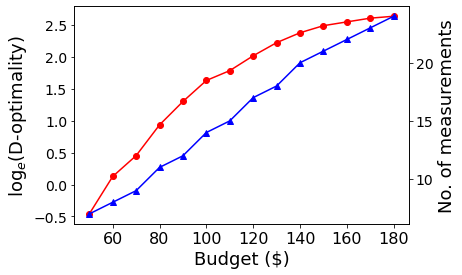

In [27]:
fig, ax = plt.subplots()

line1, =ax.plot(budget, ln_det, marker='o', color="red", label='D-optimality')
ax.set_xlabel('Budget ($)', fontsize=18)
ax.set_ylabel('log$_e$(D-optimality)', fontsize=18)
plt.xticks(fontsize=16)
ax.tick_params(axis='y', labelsize=14)

ax2 = ax.twinx()
line2, =ax2.plot(budget, no_m, marker='^', color="blue", label='No. of measurements')
ax2.set_ylabel('No. of measurements', fontsize=18)
ax2.tick_params(axis='y', labelsize=14)

#ax.legend(handles=[line1, line2])
plt.show()

fig.savefig('twinx.jpg',
            format='jpeg',
            dpi=200,
            bbox_inches='tight')

### tests

In [ ]:

test = [[1,0,0,5,0,0,9,0,0],
        [0,1,0,0,5,0,0,9,0],
        [0,0,1,0,0,5,0,0,9],
        [5,0,0,4,0,0,6,0,0],
        [0,5,0,0,4,0,0,6,0],
        [0,0,5,0,0,4,0,0,6],
        [9,0,0,6,0,0,4,0,0],
        [0,9,0,0,6,0,0,4,0],
        [0,0,9,0,0,6,0,0,4]]

test1 = np.asarray(test)

In [ ]:
print(np.linalg.inv(test1))